# 09.1c: Black Hole Cluster Neighborhood

**Find all tokens within a configurable radius of the black hole centroid**

Now that we have the centroid, let's cast a sphere around it and see what we catch. This gives us the "neighborhood" of the black hole cluster - all tokens that live nearby in γ-space.

## Strategy

1. Load the centroid from 09.1b
2. Compute distances from all 151,936 tokens to centroid
3. Filter for tokens within radius r (configurable parameter)
4. Save token IDs for downstream analysis

By making the radius configurable, we can tune it to capture exactly the population we want to study.

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

CENTROID_FILE = "black_hole_centroid_qwen3_4b.safetensors"
CENTROID_KEY = "centroid"

BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# Search parameters
SEARCH_RADIUS = 0.1  # L2 distance in γ-space
DISTANCE_METRIC = "l2"  # "l2" or "linf"

# Output file
OUTPUT_FILE = f"cluster_neighborhood_r{SEARCH_RADIUS:.3f}.safetensors"
TOKEN_IDS_KEY = "token_ids"
DISTANCES_KEY = "distances"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
N, d = gamma.shape
print(f"  Shape: ({N:,}, {d:,})")
print()

print("Loading centroid...")
centroid_data = load_file(data_dir / CENTROID_FILE)
centroid = centroid_data[CENTROID_KEY]
print(f"  Shape: {centroid.shape}")
print(f"  L2 norm: {torch.norm(centroid, p=2).item():.6f}")
print()

print("Loading black hole mask (for reference)...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
n_bh = black_hole_mask.sum().item()
print(f"  Black holes: {n_bh:,} tokens")
print()

print("✓ Data loaded")

Loading gamma matrix...
  Shape: (151,936, 2,560)

Loading centroid...
  Shape: torch.Size([2560])
  L2 norm: 0.166061

Loading black hole mask (for reference)...
  Black holes: 2,100 tokens

✓ Data loaded


## Compute Distances to Centroid

In [4]:
print(f"Computing {DISTANCE_METRIC.upper()} distances from all tokens to centroid...\n")

diffs = gamma - centroid.unsqueeze(0)

if DISTANCE_METRIC == "l2":
    distances = torch.norm(diffs, p=2, dim=1)
elif DISTANCE_METRIC == "linf":
    distances = torch.abs(diffs).max(dim=1)[0]
else:
    raise ValueError(f"Unknown distance metric: {DISTANCE_METRIC}")

print(f"Distance statistics (all {N:,} tokens):")
print(f"  Min:    {distances.min().item():.6f}")
print(f"  Max:    {distances.max().item():.6f}")
print(f"  Mean:   {distances.mean().item():.6f}")
print(f"  Median: {distances.median().item():.6f}")
print()

print("✓ Distances computed")

Computing L2 distances from all tokens to centroid...

Distance statistics (all 151,936 tokens):
  Min:    0.000017
  Max:    1.571872
  Mean:   1.050221
  Median: 1.088247

✓ Distances computed


## Find Tokens Within Radius

In [5]:
print(f"Finding tokens within radius {SEARCH_RADIUS}...\n")

within_radius = distances <= SEARCH_RADIUS
n_found = within_radius.sum().item()

print(f"Tokens found: {n_found:,} / {N:,} ({100 * n_found / N:.2f}%)")
print()

# Extract token IDs and their distances
token_ids = torch.where(within_radius)[0]
token_distances = distances[within_radius]

print(f"Token IDs shape: {token_ids.shape}")
print(f"Distances shape: {token_distances.shape}")
print()

# How many are black holes?
is_black_hole = black_hole_mask[token_ids]
n_bh_captured = is_black_hole.sum().item()
n_non_bh = n_found - n_bh_captured

print(f"Breakdown:")
print(f"  Black holes:     {n_bh_captured:,} / {n_bh:,} ({100 * n_bh_captured / n_bh:.1f}%)")
print(f"  Non-black holes: {n_non_bh:,}")
print()

print("✓ Neighborhood identified")

Finding tokens within radius 0.1...

Tokens found: 2,586 / 151,936 (1.70%)

Token IDs shape: torch.Size([2586])
Distances shape: torch.Size([2586])

Breakdown:
  Black holes:     2,100 / 2,100 (100.0%)
  Non-black holes: 486

✓ Neighborhood identified


## Distance Distribution

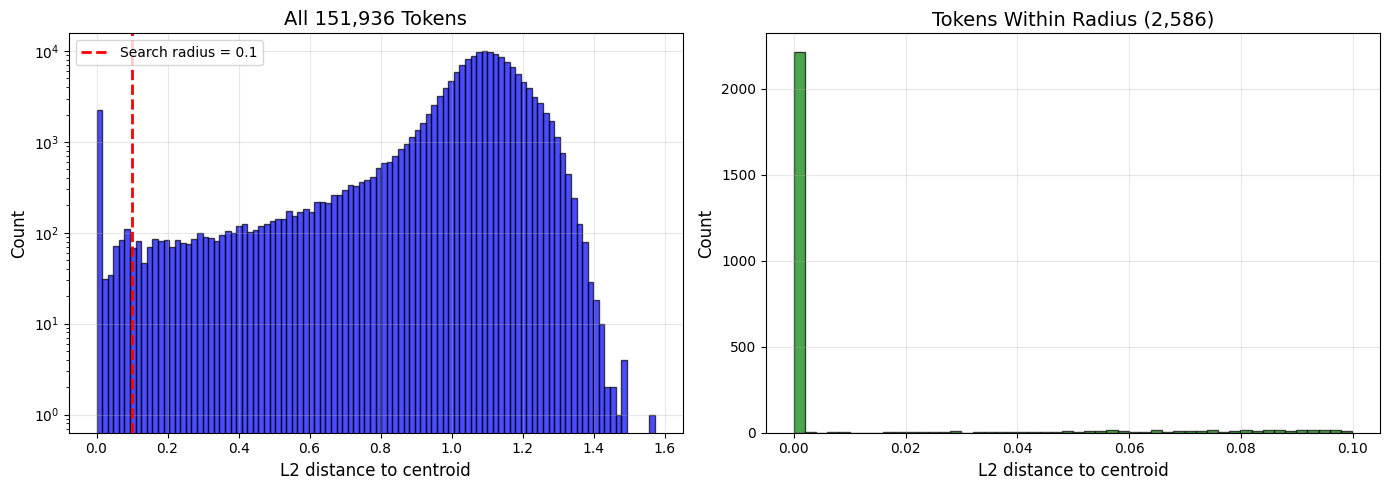

✓ Distance distribution plotted


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Panel 1: All tokens (log scale)
ax = axes[0]
ax.hist(distances.cpu().numpy(), bins=100, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(SEARCH_RADIUS, color='red', linestyle='--', linewidth=2,
           label=f'Search radius = {SEARCH_RADIUS}')
ax.set_xlabel(f'{DISTANCE_METRIC.upper()} distance to centroid', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'All {N:,} Tokens', fontsize=14)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Tokens within radius (linear scale)
ax = axes[1]
ax.hist(token_distances.cpu().numpy(), bins=50, alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel(f'{DISTANCE_METRIC.upper()} distance to centroid', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Tokens Within Radius ({n_found:,})', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distance distribution plotted")

## Distance Statistics for Captured Tokens

In [7]:
print(f"Distance statistics for {n_found:,} captured tokens:\n")

print(f"  Min:    {token_distances.min().item():.6f}")
print(f"  Max:    {token_distances.max().item():.6f}")
print(f"  Mean:   {token_distances.mean().item():.6f}")
print(f"  Median: {token_distances.median().item():.6f}")
print(f"  Std:    {token_distances.std().item():.6f}")
print()

# Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("Percentiles:")
for p in percentiles:
    val = torch.quantile(token_distances, p / 100.0).item()
    print(f"  {p:2d}%: {val:.6f}")

Distance statistics for 2,586 captured tokens:

  Min:    0.000017
  Max:    0.099899
  Mean:   0.009639
  Median: 0.000018
  Std:    0.025068

Percentiles:
  10%: 0.000017
  25%: 0.000017
  50%: 0.000018
  75%: 0.000022
  90%: 0.056612
  95%: 0.081397
  99%: 0.095660


## Save Results

In [8]:
output_path = data_dir / OUTPUT_FILE

print(f"Saving neighborhood to {output_path}...\n")

save_file({
    TOKEN_IDS_KEY: token_ids,
    DISTANCES_KEY: token_distances
}, output_path)

print(f"  Tokens saved:  {n_found:,}")
print(f"  File size:     {output_path.stat().st_size / 1024:.2f} KB")
print()
print(f"✓ Neighborhood saved to {OUTPUT_FILE}")
print()
print("To load in future notebooks:")
print(f"  data = load_file('{OUTPUT_FILE}')")
print(f"  token_ids = data['{TOKEN_IDS_KEY}']")
print(f"  distances = data['{DISTANCES_KEY}']")

Saving neighborhood to ../data/tensors/cluster_neighborhood_r0.100.safetensors...

  Tokens saved:  2,586
  File size:     30.45 KB

✓ Neighborhood saved to cluster_neighborhood_r0.100.safetensors

To load in future notebooks:
  data = load_file('cluster_neighborhood_r0.100.safetensors')
  token_ids = data['token_ids']
  distances = data['distances']


## Summary

In [9]:
print("="*80)
print("CLUSTER NEIGHBORHOOD SUMMARY")
print("="*80)
print()
print(f"Search radius:        {SEARCH_RADIUS}")
print(f"Distance metric:      {DISTANCE_METRIC.upper()}")
print(f"Tokens captured:      {n_found:,} / {N:,} ({100 * n_found / N:.2f}%)")
print()
print(f"Breakdown:")
print(f"  Black holes:        {n_bh_captured:,} ({100 * n_bh_captured / n_found:.1f}% of captured)")
print(f"  Non-black holes:    {n_non_bh:,} ({100 * n_non_bh / n_found:.1f}% of captured)")
print()
print(f"Mean distance:        {token_distances.mean().item():.6f}")
print(f"Max distance:         {token_distances.max().item():.6f}")
print()
print("="*80)

CLUSTER NEIGHBORHOOD SUMMARY

Search radius:        0.1
Distance metric:      L2
Tokens captured:      2,586 / 151,936 (1.70%)

Breakdown:
  Black holes:        2,100 (81.2% of captured)
  Non-black holes:    486 (18.8% of captured)

Mean distance:        0.009639
Max distance:         0.099899



## Conclusion

**What we found:**
- Number of tokens within search radius
- Breakdown: black holes vs. non-black holes
- Distance distribution of captured tokens

**Tuning the radius:**
- Too small: miss interesting structure around black holes
- Too large: capture too many irrelevant tokens, expensive pairwise distances
- Sweet spot: captures black holes + nearest neighbors

**Next steps:**
- 09.1d: Compute pairwise distances for this neighborhood
- 09.1e: Build adjacency graph with threshold ε
- 09.1f: Analyze connected components